#### This requires lag-llama project cloned to work, won't work, but located here to push to remote

In [130]:
from itertools import islice

from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from tqdm.autonotebook import tqdm

import torch
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.repository.datasets import get_dataset

from gluonts.dataset.pandas import PandasDataset
import pandas as pd

from lag_llama.gluon.estimator import LagLlamaEstimator

<Axes: title={'center': 'All-Transactions House Price Index for California'}, xlabel='time', ylabel='Index value'>

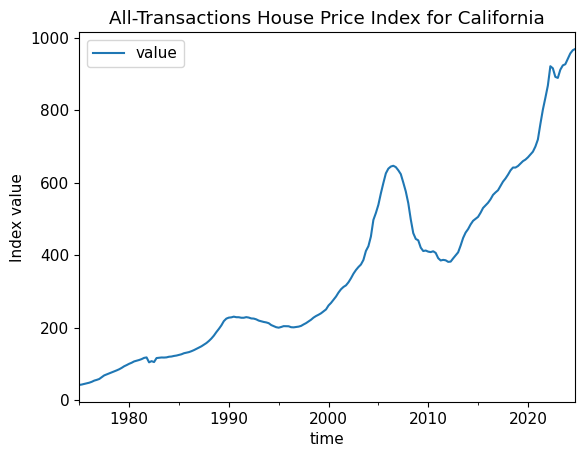

In [131]:
import os

df = pd.read_csv(os.path.join('..', '..', 'Datasets', 'CASTHPI.csv'))
df.rename(columns={'observation_date': 'date', 'CASTHPI': 'value'}, inplace=True)
df['date'] = pd.to_datetime(df['date'])
df['value'] = df['value'].astype('float32')
df.set_index('date', inplace=True)

df.plot(
    xlabel='time',
    ylabel='Index value',
    title='All-Transactions House Price Index for California',
)

In [132]:
train_end = round(len(df) * 0.7)
valid_end = round(len(df) * 0.9)

train = PandasDataset(df[:train_end], freq="Q", target="value")
valid = PandasDataset(df[train_end:valid_end], freq="Q", target="value")
test = PandasDataset(df[valid_end:], freq="Q", target="value")

In [ ]:
#predict next 1 years (4 quarters) of data
prediction_length = 4
context_length = prediction_length * 3 # look at 3 years back
num_samples = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 32

In [165]:
ckpt = torch.load('lag-llama.ckpt', map_location=device)
estimator_args = ckpt['hyper_parameters']['model_kwargs']

zs_estimator = LagLlamaEstimator(
    ckpt_path='lag-llama.ckpt',
    prediction_length=prediction_length,
    context_length=context_length,
    device=device,

    #estimator args
    input_size=estimator_args['input_size'],
    n_layer=estimator_args['n_layer'],
    n_embd_per_head=estimator_args['n_embd_per_head'],
    n_head=estimator_args['n_head'],
    scaling=estimator_args['scaling'],
    time_feat=estimator_args['time_feat'],

    nonnegative_pred_samples=True,

    rope_scaling={
        "type": "linear",
        "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
    },
    batch_size=batch_size,
    num_parallel_samples=num_samples
)

zs_predictor = zs_estimator.create_predictor(zs_estimator.create_transformation(), zs_estimator.create_lightning_module())

In [146]:
print(f'valid dataset index 0: {df[train_end:valid_end].index[0]}')
print(f'test dataset index 0: {df[valid_end:].index[0]}')

valid dataset index 0: 2010-01-01 00:00:00
test dataset index 0: 2020-01-01 00:00:00


In [166]:
date_list = pd.date_range(df[valid_end:].index[1], periods=5, freq='Y').to_list()
print(date_list)

zs_forecasts = []
zs_tss = []

for d in date_list:
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=PandasDataset(df[:d], freq="Q", target="value"),
        predictor=zs_predictor,
        num_samples=num_samples,
    )
    zs_forecasts.append(list(forecast_it))
    zs_tss.append(list(ts_it))


[Timestamp('2020-12-31 00:00:00'), Timestamp('2021-12-31 00:00:00'), Timestamp('2022-12-31 00:00:00'), Timestamp('2023-12-31 00:00:00'), Timestamp('2024-12-31 00:00:00')]


In [167]:
evaluator = Evaluator()
zs_a_metrics = [] 
zs_t_metrics = []

for (t, s) in zip(zs_tss, zs_forecasts):
    agg_metrics, ts_metrics = evaluator(t, s)
    zs_a_metrics.append(agg_metrics)
    zs_t_metrics.append(ts_metrics)

Running evaluation: 1it [00:00, 166.71it/s]
Running evaluation: 1it [00:00, 125.00it/s]
Running evaluation: 1it [00:00, 142.81it/s]
Running evaluation: 1it [00:00, 166.63it/s]
Running evaluation: 1it [00:00, 166.69it/s]


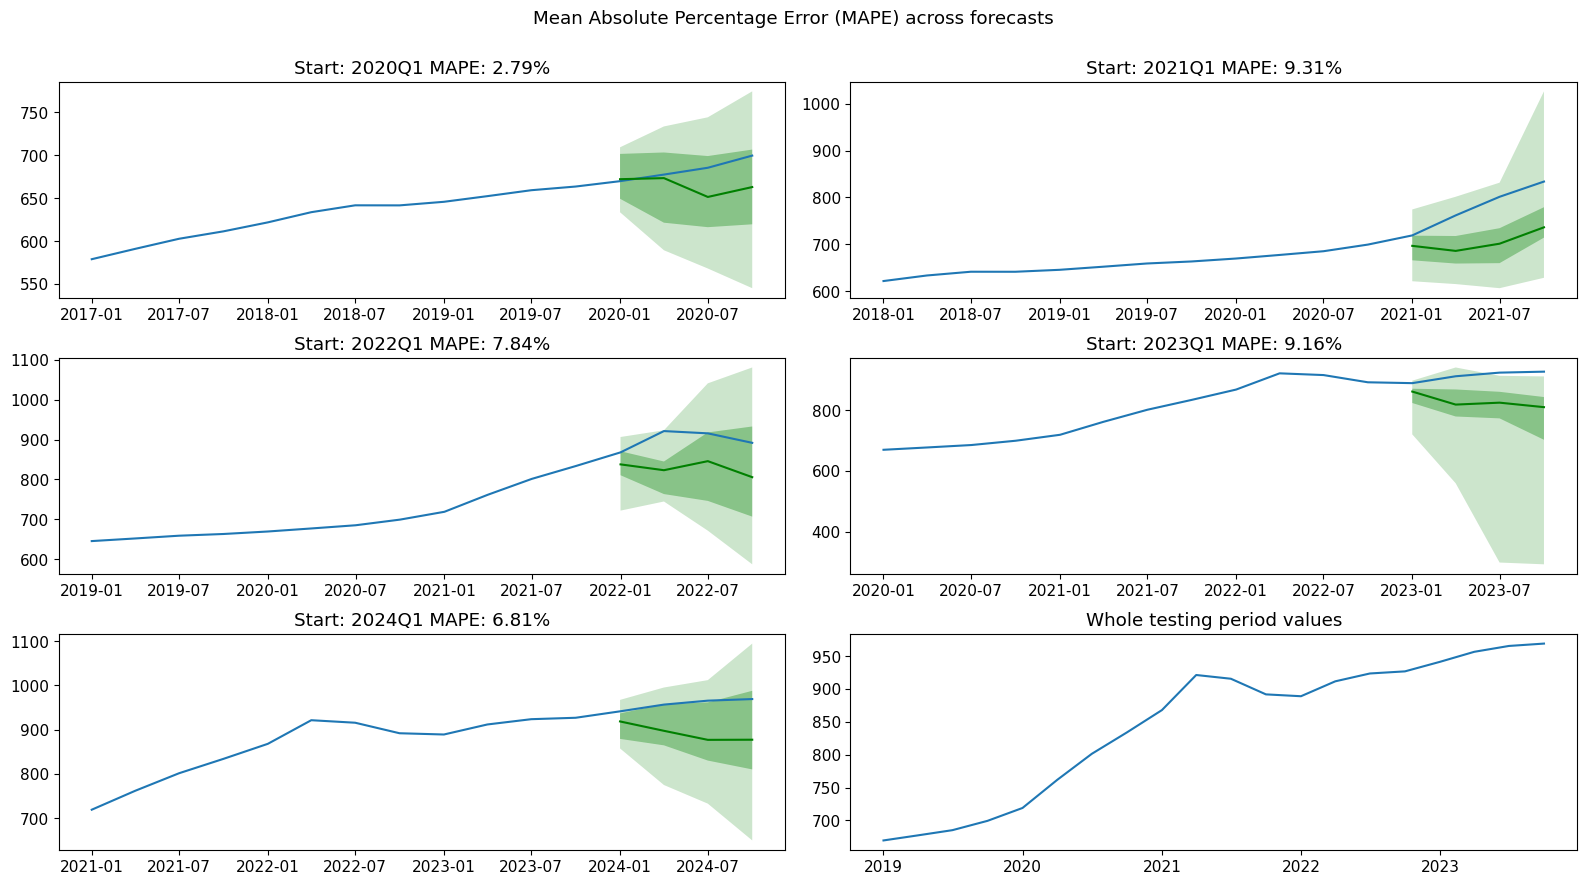

In [173]:
plt.figure(figsize=(16, 9))
plt.rcParams.update({'font.size': 11})

for idx in range(len(zs_forecasts)):
    ax = plt.subplot(3, 2, idx + 1)
    t = zs_tss[idx][0][zs_forecasts[idx][0].start_date.to_timestamp() - pd.DateOffset(years=3):]

    smape = float(f'{zs_t_metrics[idx]["MAPE"][0]:.4f}') * 100.0
    smape = float(f'{smape:.2f}')

    ax.set_title("Start: " + str(zs_t_metrics[idx]["forecast_start"][0]) + " MAPE: " + str(smape) + "%")
    plt.plot(t.index.to_timestamp(), t)
    # ax.set_xticklabels([])

    zs_forecasts[idx][0].plot(color='g')

ax = plt.subplot(3, 2, len(zs_forecasts)+1)
ax.set_title(f'Whole testing period values')
plt.plot(df[valid_end:].index - pd.DateOffset(years=1), df[valid_end:]['value'])

plt.gcf().tight_layout()
plt.subplots_adjust(top=0.9)
plt.suptitle("Mean Absolute Percentage Error (MAPE) across forecasts")
plt.show()

In [174]:
ckpt = torch.load("lag-llama.ckpt", map_location=device)
estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

finetune_estimator = LagLlamaEstimator(
    ckpt_path="lag-llama.ckpt",
    prediction_length=prediction_length,
    context_length=64,

    nonnegative_pred_samples=True,
    aug_prob=0,
    lr=5e-4,
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),

    # estimator args
    input_size=estimator_args["input_size"],
    n_layer=estimator_args["n_layer"],
    n_embd_per_head=estimator_args["n_embd_per_head"],
    n_head=estimator_args["n_head"],
    time_feat=estimator_args["time_feat"],

    # linear positional encoding scaling
    rope_scaling={
        "type": "linear",
        "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
    },

    batch_size=64,
    num_parallel_samples=num_samples,
    trainer_kwargs = {"max_epochs": 50,} # lightning trainer arguments
)

In [175]:
finetuned_predictor = finetune_estimator.train(train, valid, cache_data=True, shuffle_buffer_length=1000)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\krzys\miniconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\logger_connector\logger_connector.py:67: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
Missing logger folder: c:\Users\krzys\Desktop\Eksploracja Danych\SecondAnalysis\lag-llama\lightning_logs

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
---------------------

Epoch 0: |          | 50/? [00:42<00:00,  1.17it/s, v_num=0]               

Epoch 0, global step 50: 'val_loss' reached 4.60152 (best 4.60152), saving model to 'c:\\Users\\krzys\\Desktop\\Eksploracja Danych\\SecondAnalysis\\lag-llama\\lightning_logs\\version_0\\checkpoints\\epoch=0-step=50.ckpt' as top 1


Epoch 1: |          | 50/? [00:42<00:00,  1.17it/s, v_num=0]

Epoch 1, global step 100: 'val_loss' was not in top 1


Epoch 2: |          | 50/? [00:43<00:00,  1.14it/s, v_num=0]

Epoch 2, global step 150: 'val_loss' was not in top 1


Epoch 3: |          | 50/? [00:43<00:00,  1.14it/s, v_num=0]

Epoch 3, global step 200: 'val_loss' was not in top 1


Epoch 4: |          | 50/? [00:45<00:00,  1.10it/s, v_num=0]

Epoch 4, global step 250: 'val_loss' was not in top 1


Epoch 5: |          | 50/? [00:45<00:00,  1.09it/s, v_num=0]

Epoch 5, global step 300: 'val_loss' was not in top 1


Epoch 6: |          | 13/? [00:11<00:00,  1.09it/s, v_num=0]

c:\Users\krzys\miniconda3\Lib\site-packages\lightning\pytorch\trainer\call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [176]:
date_list = pd.date_range(df[valid_end:].index[1], periods=5, freq='Y').to_list()
print(date_list)

finetune_forecasts  = []
finetune_tss  = []

for d in date_list:
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=PandasDataset(df[:d], freq="Q", target="value"),
        predictor=finetuned_predictor,
        num_samples=num_samples,
    )
    finetune_forecasts.append(list(forecast_it))
    finetune_tss.append(list(ts_it))


[Timestamp('2020-12-31 00:00:00'), Timestamp('2021-12-31 00:00:00'), Timestamp('2022-12-31 00:00:00'), Timestamp('2023-12-31 00:00:00'), Timestamp('2024-12-31 00:00:00')]


In [177]:
finetune_a_metrics = []
finetune_t_metrics = []

for (t, s) in zip(finetune_tss, finetune_forecasts):
    agg_metrics, ts_metrics = evaluator(t, s)
    finetune_a_metrics.append(agg_metrics)
    finetune_t_metrics.append(ts_metrics)

Running evaluation: 1it [00:00, 90.92it/s]
Running evaluation: 1it [00:00, 100.03it/s]
Running evaluation: 1it [00:00, 166.69it/s]
Running evaluation: 1it [00:00, 166.66it/s]
Running evaluation: 1it [00:00, 111.11it/s]


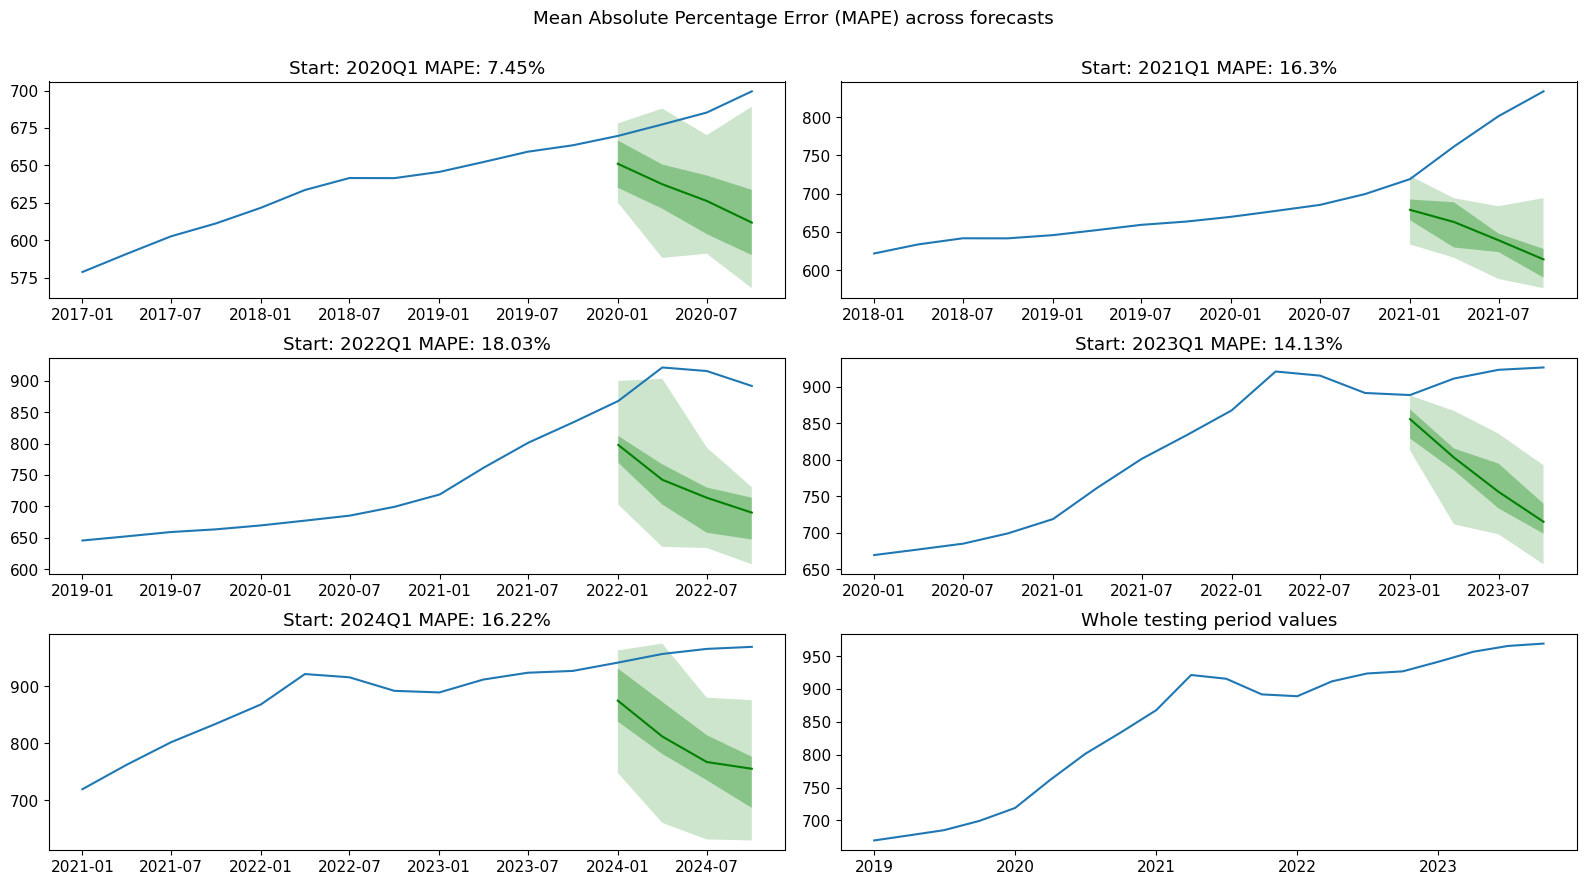

In [179]:
plt.figure(figsize=(16, 9))
plt.rcParams.update({'font.size': 11})

for idx in range(len(finetune_forecasts)):
    ax = plt.subplot(3, 2, idx + 1)
    t = finetune_tss[idx][0][finetune_forecasts[idx][0].start_date.to_timestamp() - pd.DateOffset(years=3):]

    smape = float(f'{finetune_t_metrics[idx]["MAPE"][0]:.4f}') * 100.0
    smape = float(f'{smape:.2f}')

    ax.set_title("Start: " + str(finetune_t_metrics[idx]["forecast_start"][0]) + " MAPE: " + str(smape) + "%")
    plt.plot(t.index.to_timestamp(), t)
    # ax.set_xticklabels([])

    finetune_forecasts[idx][0].plot(color='g')

ax = plt.subplot(3, 2, len(finetune_forecasts)+1)
ax.set_title(f'Whole testing period values')
plt.plot(df[valid_end:].index - pd.DateOffset(years=1), df[valid_end:]['value'])

plt.gcf().tight_layout()
plt.subplots_adjust(top=0.9)
plt.suptitle("Mean Absolute Percentage Error (MAPE) across forecasts")
plt.show()

*It look like training our own model failed, probalby because of lack of data*
